c:\Users\Indira Fiksik\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:18:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.8031799645789354
F1 Score: 0.10453648915187377
Accuracy: 0.9495555555555556
Recall: 0.05767138193688792
Precision: 0.5578947368421052


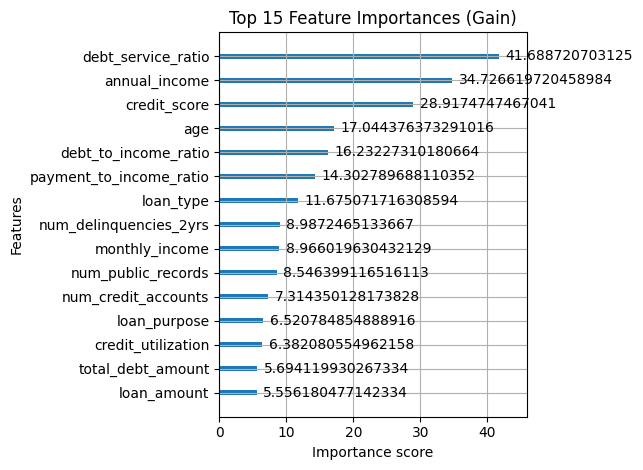

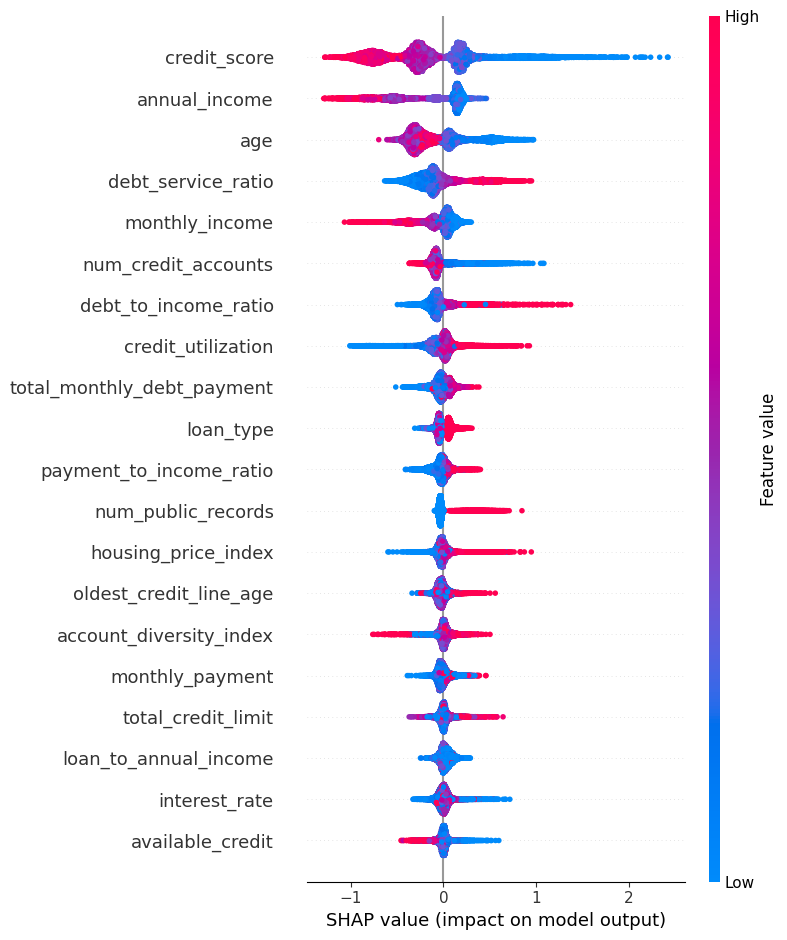

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt

# ---- 1. Load Data ----
df = pd.read_csv(r'final_dataset.csv')  # Change the filename as needed

# ---- 2. Drop IDs and Noise ----
df = df.drop(['id', 'application_id', 'referral_code', 'random_noise_1'], axis=1)

# ---- 3. Encode Categorical Features ----
categorical_cols = [
    'preferred_contact', 'account_status_code', 'loan_type', 'loan_purpose',
    'employment_type', 'education', 'marital_status'
]
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# ---- 4. Train/Test Split ----
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- 5. Train XGBoost ----
model = xgb.XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05, n_jobs=-1,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
model.fit(X_train, y_train)

# ---- 6. Predict and Evaluate ----
preds_proba = model.predict_proba(X_test)[:, 1]
preds = model.predict(X_test)
print('AUC:', roc_auc_score(y_test, preds_proba))
print('F1 Score:', f1_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))
print('Recall:', recall_score(y_test, preds))
print('Precision:', precision_score(y_test, preds))

# ---- 7. Feature Importance (Plot) ----
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('Top 15 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

# ---- 8. SHAP for Interpretation ----
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [7]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

thresholds = np.arange(0.01, 0.50, 0.01)
f1s, recalls, precisions = [], [], []
for t in thresholds:
    preds_custom = (preds_proba > t).astype(int)
    f1s.append(f1_score(y_test, preds_custom))
    recalls.append(recall_score(y_test, preds_custom))
    precisions.append(precision_score(y_test, preds_custom))
for i, t in enumerate(thresholds):
    print(f"Threshold: {t:.2f} | F1: {f1s[i]:.3f} | Recall: {recalls[i]:.3f} | Precision: {precisions[i]:.3f}")

# Find threshold with highest F1
best_idx = np.argmax(f1s)
print(f"Best F1: {f1s[best_idx]:.3f} at threshold {thresholds[best_idx]:.2f}")


Threshold: 0.01 | F1: 0.121 | Recall: 0.959 | Precision: 0.064
Threshold: 0.02 | F1: 0.149 | Recall: 0.894 | Precision: 0.081
Threshold: 0.03 | F1: 0.180 | Recall: 0.829 | Precision: 0.101
Threshold: 0.04 | F1: 0.204 | Recall: 0.754 | Precision: 0.118
Threshold: 0.05 | F1: 0.224 | Recall: 0.686 | Precision: 0.134
Threshold: 0.06 | F1: 0.245 | Recall: 0.641 | Precision: 0.152
Threshold: 0.07 | F1: 0.263 | Recall: 0.601 | Precision: 0.169
Threshold: 0.08 | F1: 0.274 | Recall: 0.561 | Precision: 0.182
Threshold: 0.09 | F1: 0.285 | Recall: 0.528 | Precision: 0.195
Threshold: 0.10 | F1: 0.292 | Recall: 0.490 | Precision: 0.208
Threshold: 0.11 | F1: 0.296 | Recall: 0.455 | Precision: 0.220
Threshold: 0.12 | F1: 0.301 | Recall: 0.430 | Precision: 0.231
Threshold: 0.13 | F1: 0.303 | Recall: 0.405 | Precision: 0.242
Threshold: 0.14 | F1: 0.306 | Recall: 0.384 | Precision: 0.255
Threshold: 0.15 | F1: 0.307 | Recall: 0.365 | Precision: 0.266
Threshold: 0.16 | F1: 0.307 | Recall: 0.346 | Precision

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from collections import Counter

# ---- Load Data ----
df = pd.read_csv(r'final_dataset.csv')

ids = df['id']
# ---- Drop columns not used for modeling ----
drop_cols = ['id', 'application_id', 'referral_code', 'random_noise_1']
df = df.drop(drop_cols, axis=1)

# ---- Encode Categorical Features ----
categorical_cols = [
    'preferred_contact', 'account_status_code', 'loan_type', 'loan_purpose',
    'employment_type', 'education', 'marital_status'
]
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# ---- Train/Test Split ----
X = df.drop('default', axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
id_test = ids[X_test.index]

print(f"Original train class distribution: {Counter(y_train)}")

# ---- SMOTE Oversampling ----
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Resampled train class distribution: {Counter(y_train_smote)}")

# ---- Train Logistic Regression ----
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)

# ---- Model Evaluation ----
preds_proba = model.predict_proba(X_test)[:, 1]
preds = (preds_proba > 0.5).astype(int)  # Use threshold tuning for higher F1

print('AUC:', roc_auc_score(y_test, preds_proba))
print('F1 Score:', f1_score(y_test, preds))
print('Accuracy:', accuracy_score(y_test, preds))
print('Recall:', recall_score(y_test, preds))
print('Precision:', precision_score(y_test, preds))

# ---- Threshold Loop ----
import numpy as np
thresholds = np.arange(0.05, 0.55, 0.05)
results = []
for t in thresholds:
    preds_t = (preds_proba > t).astype(int)
    f1 = f1_score(y_test, preds_t)
    rec = recall_score(y_test, preds_t)
    prec = precision_score(y_test, preds_t)
    results.append((t, f1, rec, prec))
    print(f"Threshold: {t:.2f} | F1: {f1:.3f} | Recall: {rec:.3f} | Precision: {prec:.3f}")
best = max(results, key=lambda x: x[1])
print(f"\nBest F1: {best[1]:.3f} at threshold {best[0]:.2f} (Recall: {best[2]:.3f}, Precision: {best[3]:.3f})")

eval_set = pd.DataFrame({
    'id': id_test.values,              # The correct IDs for the test set
    'default': y_test.values,          # Actual test defaults (0/1)
    'prob_default': preds_proba        # Your model's predicted probability
})

# Save as CSV for submission
eval_set.to_csv('evaluation_set.csv', index=False)
print(eval_set.head())



Original train class distribution: Counter({0: 68324, 1: 3675})
Resampled train class distribution: Counter({0: 68324, 1: 68324})
AUC: 0.795037903953632
F1 Score: 0.20500305064063454
Accuracy: 0.7104444444444444
Recall: 0.7312295973884657
Precision: 0.11921234699308142
Threshold: 0.05 | F1: 0.103 | Recall: 0.995 | Precision: 0.054
Threshold: 0.10 | F1: 0.110 | Recall: 0.984 | Precision: 0.058
Threshold: 0.15 | F1: 0.119 | Recall: 0.975 | Precision: 0.063
Threshold: 0.20 | F1: 0.127 | Recall: 0.948 | Precision: 0.068
Threshold: 0.25 | F1: 0.136 | Recall: 0.913 | Precision: 0.073
Threshold: 0.30 | F1: 0.147 | Recall: 0.886 | Precision: 0.080
Threshold: 0.35 | F1: 0.159 | Recall: 0.852 | Precision: 0.088
Threshold: 0.40 | F1: 0.173 | Recall: 0.817 | Precision: 0.097
Threshold: 0.45 | F1: 0.189 | Recall: 0.782 | Precision: 0.108
Threshold: 0.50 | F1: 0.205 | Recall: 0.731 | Precision: 0.119

Best F1: 0.205 at threshold 0.50 (Recall: 0.731, Precision: 0.119)
      id  default  prob_default


c:\Users\Indira Fiksik\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
